In [88]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import sys
import os
import importlib
from scipy.stats import t, norm, gaussian_kde, probplot
from scipy.optimize import minimize

# add utils path
src_path = os.path.abspath('../../')
if src_path not in sys.path:
    sys.path.append(src_path)

# import custom functions
from src.utils import plotting

# reload module on change
importlib.reload(sys.modules['src.utils.plotting']) 

<module 'src.utils.plotting' from 'c:\\Users\\Yang\\Documents\\Projects\\funance_blog\\src\\utils\\plotting.py'>

In [2]:
# 5 years of historical prices
TICKER = 'COST'
end = datetime.today()
start = end - timedelta(days=10*365)
end_date = end.strftime('%Y-%m-%d')
start_date = start.strftime('%Y-%m-%d')

prices = yf.download(TICKER, start=start_date, end=end_date)['Adj Close']

# returns
returns = np.log(prices / prices.shift(1)).dropna()
mean = returns.mean()
std = returns.std()

[*********************100%%**********************]  1 of 1 completed


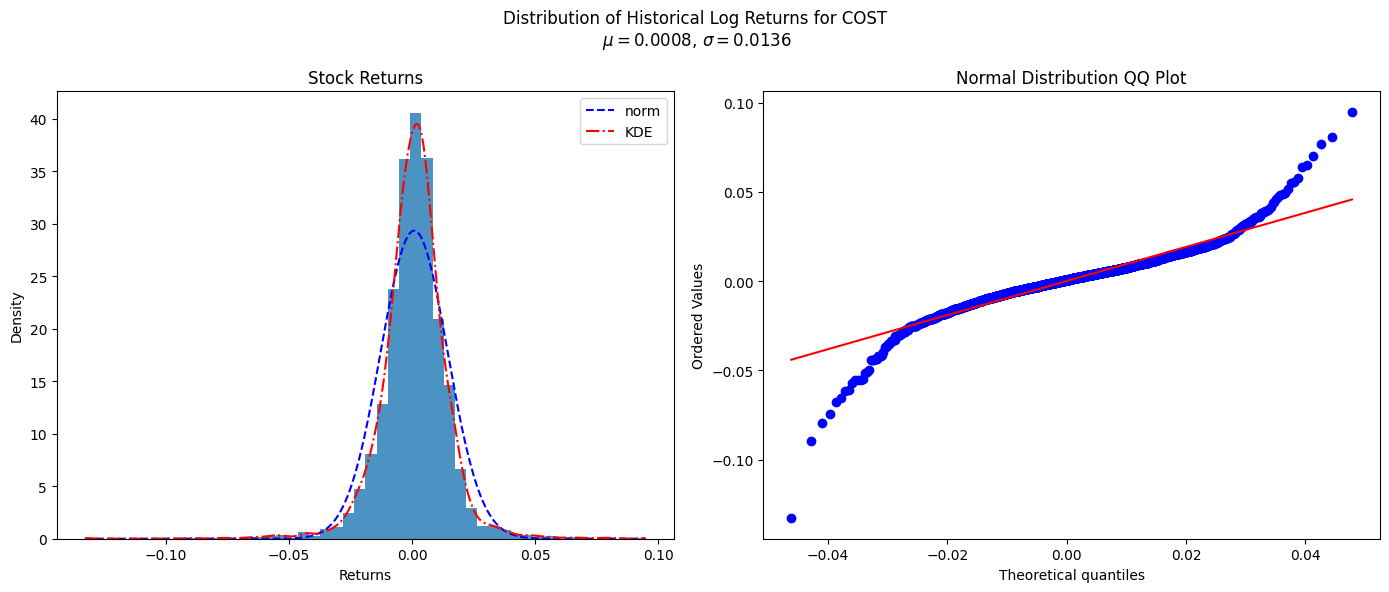

In [89]:
# hist plots
plotting.plot_dist(
    returns, 
    f'Distribution of Historical Log Returns for {TICKER}'
)

In [3]:
# non-parametric VaR and ES
alpha = 0.01
T = '1 day'
position = 10000

VaR = np.percentile(returns, alpha*100) * -position
ES = returns[returns < np.percentile(returns, alpha*100)].mean() * -position

print(f'VaR({alpha}, {T}) = ${VaR:.2f}')
print(f'ES({alpha}, {T}) = ${ES:.2f}')

VaR(0.01, 1 day) = $391.30
ES(0.01, 1 day) = $573.25


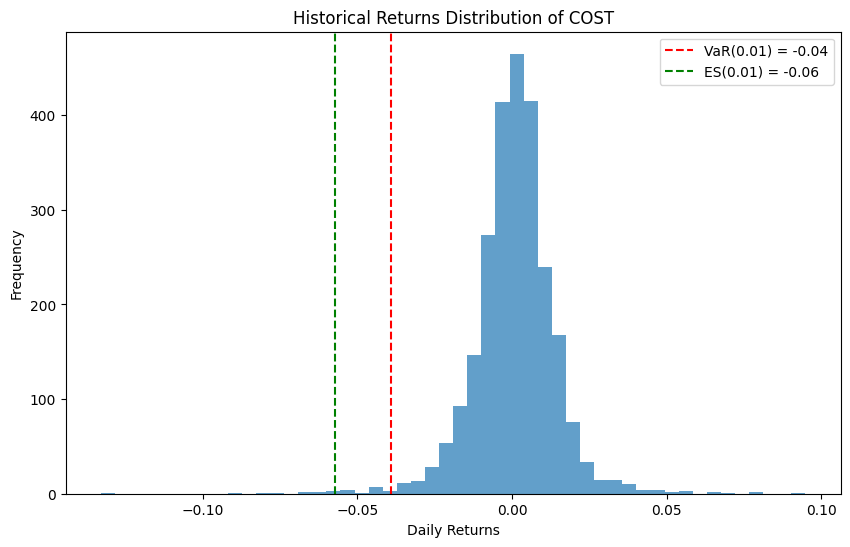

In [4]:
# plot non parametric VaR and ES on returns distribution
plt.figure(figsize=(10, 6))
plt.hist(returns, bins=50, alpha=0.7)
plt.axvline(VaR/-position, color='red', linestyle='dashed', label=f'VaR({alpha}) = {VaR/-position:.2f}')
plt.axvline(ES/-position, color='green', linestyle='dashed', label=f'ES({alpha}) = {ES/-position:.2f}')

plt.title(f'Historical Returns Distribution of {TICKER}')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()

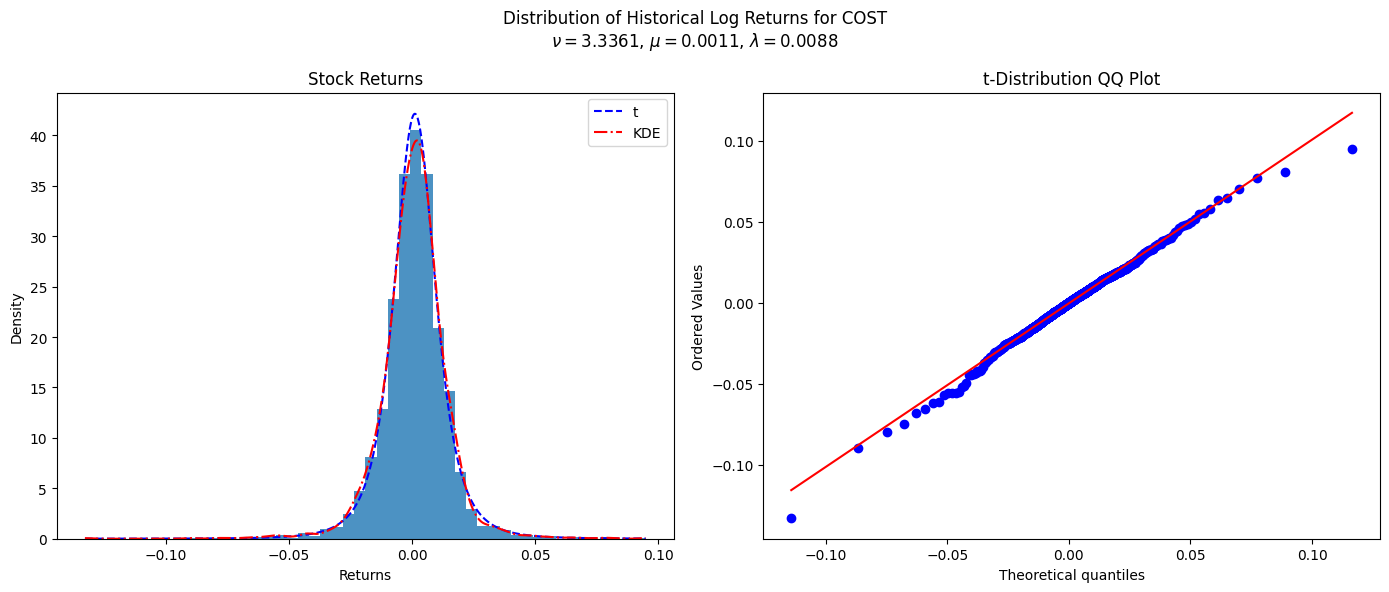

In [90]:
plotting.plot_dist(
    returns,
    f'Distribution of Historical Log Returns for {TICKER}',
    dist='t',
)

In [6]:
# parametric VaR and ES
# fit t-distribution
def compute_VaR_ES_t(returns, alpha, position):
    df, loc, scale = t.fit(returns)
    ppf = t.ppf(alpha, df)

    VaR_t = -position * (loc + scale * ppf)
    ES_t = position * (-loc + scale*(
        (t.pdf(ppf, df) / alpha) *
        ((df + ppf**2) / (df - 1))
    ))
    
    return VaR_t, ES_t

In [7]:
VaR_t, ES_t = compute_VaR_ES_t(returns, alpha, position)

print(f'VaR({alpha}, {T}) = ${VaR_t:.2f}')
print(f'ES({alpha}, {T}) = ${ES_t:.2f}')

VaR(0.01, 1 day) = $357.25
ES(0.01, 1 day) = $533.08


In [8]:
# confidence intervals
def calculate_CI(data, alpha, position, gamma=0.05, num_samples=1000):
    quantiles = [100*gamma/2, 100*(1-gamma/2)]
    df, loc, scale = t.fit(data)
    VaR_arr, ES_arr = [], []
    
    for _ in range(num_samples):
        sample = t.rvs(df, loc=loc, scale=scale, size=len(data))
        VaR, ES = compute_VaR_ES_t(sample, alpha, position)
        VaR_arr.append(VaR)
        ES_arr.append(ES)
    
    VaR_CI = np.percentile(VaR_arr, quantiles)
    ES_CI = np.percentile(ES_arr, quantiles)
    
    return VaR_CI, ES_CI, VaR_arr, ES_arr

In [9]:
# 95% confidence intervals for VaR and ES
VaR_CI, ES_CI, VaR_arr, ES_arr = calculate_CI(returns, alpha, position)

print(f'95% CI for VaR({alpha}, {T}): {VaR_CI[0].round(2), VaR_CI[1].round(2)}')
print(f'95% CI for ES({alpha}, {T}): {ES_CI[0].round(2), ES_CI[1].round(2)}')

95% CI for VaR(0.01, 1 day): (330.67, 385.51)
95% CI for ES(0.01, 1 day): (470.18, 606.07)


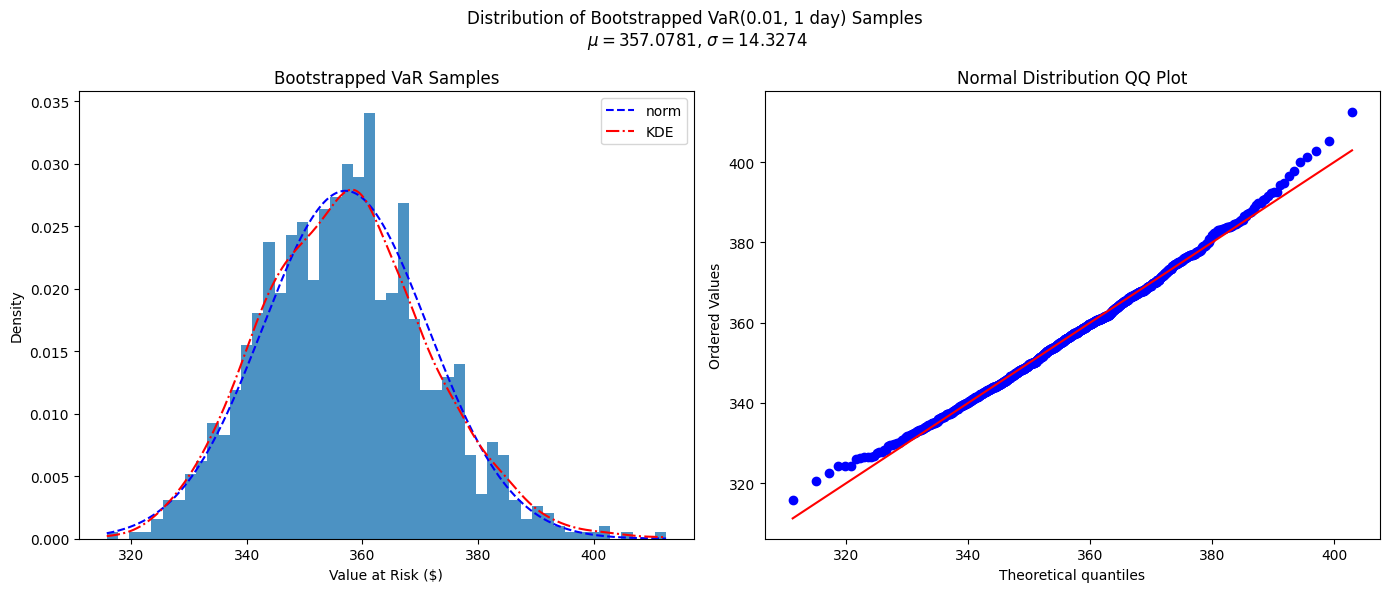

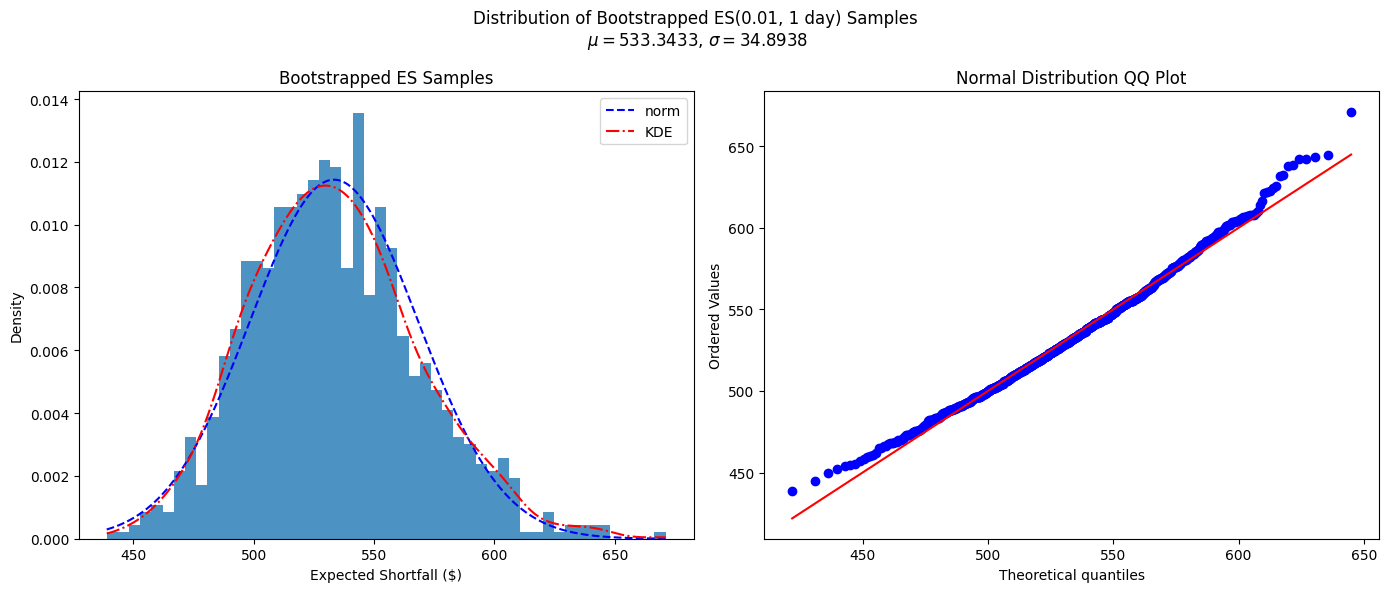

In [10]:
# central limit theorem for VaR and ES samples
plotting.plot_dist(
    VaR_arr,
    f'Distribution of Bootstrapped VaR({alpha}, {T}) Samples',
    hist_title='Bootstrapped VaR Samples',
    hist_xlabel='Value at Risk ($)'
)
plotting.plot_dist(
    ES_arr,
    f'Distribution of Bootstrapped ES({alpha}, {T}) Samples',
    hist_title='Bootstrapped ES Samples',
    hist_xlabel='Expected Shortfall ($)'
)

In [11]:
# normal approximation of VaR and ES
def normal_approx_CI(data, alpha, position, gamma=0.05, num_samples=50):
    df, loc, scale = t.fit(data)
    VaR_arr, ES_arr = [], []
    
    for _ in range(num_samples):
        sample = t.rvs(df, loc=loc, scale=scale, size=len(data))
        VaR, ES = compute_VaR_ES_t(sample, alpha, position)
        VaR_arr.append(VaR)
        ES_arr.append(ES)
    
    VaR_mean = np.mean(VaR_arr)
    VaR_se = np.sqrt(1/(len(VaR_arr)-1) * np.sum((VaR_arr - VaR_mean)**2))
    ES_mean = np.mean(ES_arr)
    ES_se = np.sqrt(1/(len(ES_arr)-1) * np.sum((ES_arr - ES_mean)**2))
    
    z = np.abs(norm.ppf(gamma/2))
    VaR_CI = VaR_mean + np.array([-1, 1]) * z * VaR_se
    ES_CI = ES_mean + np.array([-1, 1]) * z * ES_se
    
    return VaR_CI, ES_CI

In [12]:
VaR_norm_CI, ES_norm_CI = normal_approx_CI(returns, alpha, position)

print(f'95% CI for VaR({alpha}, {T}): {VaR_norm_CI[0].round(2), VaR_norm_CI[1].round(2)}')
print(f'95% CI for ES({alpha}, {T}): {ES_norm_CI[0].round(2), ES_norm_CI[1].round(2)}')

95% CI for VaR(0.01, 1 day): (326.2, 387.39)
95% CI for ES(0.01, 1 day): (457.69, 605.74)


In [20]:
# portfolio of 5 stocks, equal weights
TICKERS = ['KO', 'NRG', 'JPM', 'GOOGL', 'PG']
stock_prices = yf.download(TICKERS, start=start_date, end=end_date)['Adj Close']
log_returns = np.log(stock_prices / stock_prices.shift(1)).dropna()

[*********************100%%**********************]  5 of 5 completed


In [64]:
mu = log_returns.mean().values
weights = np.ones(len(TICKERS)) / len(TICKERS) # equal weights
cov = log_returns.cov().values

r_p = np.dot(log_returns.values, weights)
mu_p = np.dot(weights, mu)
sigma_p = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))

# fit df for each stock
dfs = []
for col in log_returns:
    df, _, _ = t.fit(log_returns.loc[:, col].values)
    dfs.append(df)

# harmonic mean of dfs
df_p = 1 / np.sum(weights/np.array(dfs))
lambda_p = sigma_p / np.sqrt(df_p/(df_p-2))

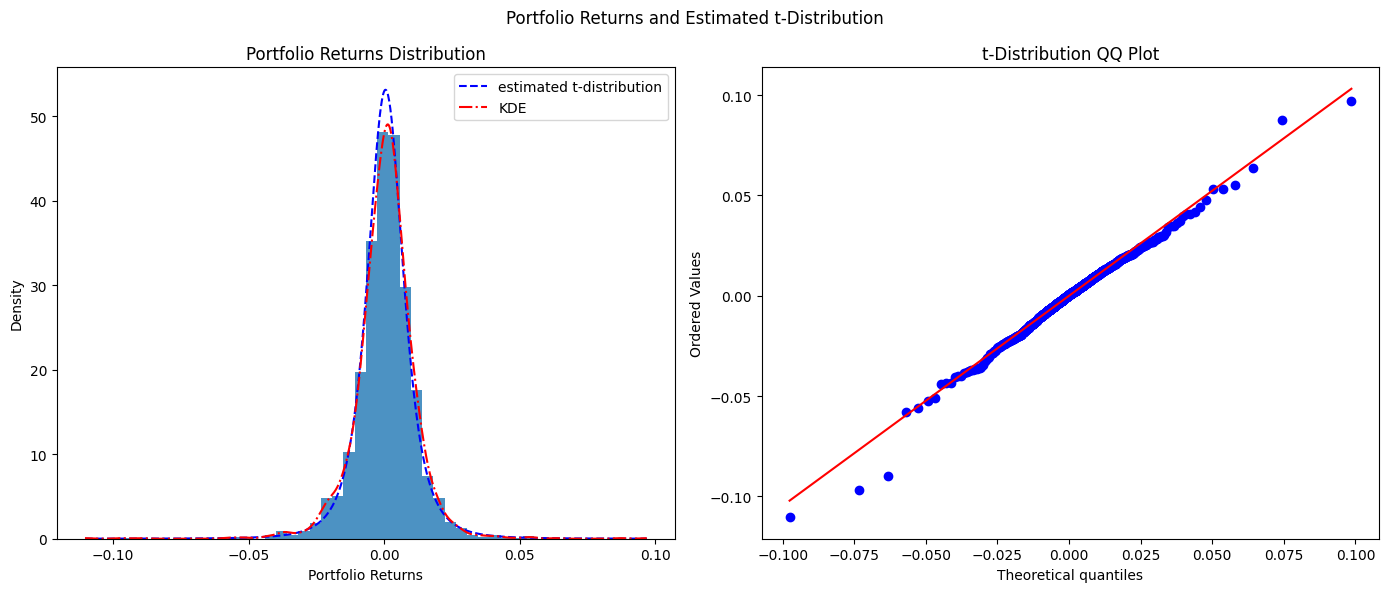

In [67]:
# portfolio returns and estimated t-distribution
kde = gaussian_kde(r_p)
x_values = np.linspace(min(r_p), max(r_p), 1000)
kde_values = kde(x_values)

t_dist = t.pdf(x_values, df_p, mu_p, lambda_p)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# histogram and KDE
axs[0].hist(r_p, bins=50, density=True, alpha=0.8)
axs[0].plot(x_values, t_dist, color='blue', linestyle='--', label='estimated t-distribution')
axs[0].plot(x_values, kde_values, color='red', linestyle='-.', label='KDE')
axs[0].set_xlabel('Portfolio Returns')
axs[0].set_ylabel('Density')
axs[0].set_title('Portfolio Returns Distribution')
axs[0].legend()

# QQ plot
probplot(r_p, plot=axs[1], dist='t', sparams=(df, mu_p, lambda_p)) 
axs[1].set_title('t-Distribution QQ Plot')

fig.suptitle('Portfolio Returns and Estimated t-Distribution')
fig.tight_layout()

In [70]:
# VaR and ES for portfolio
position_p = 10000
alpha_p = 0.01
ppf_p = t.ppf(alpha_p, df_p)

VaR_t = -position * (mu_p + lambda_p * ppf_p)
ES_t = position * (-mu_p + lambda_p*(
    (t.pdf(ppf_p, df_p) / alpha) *
    ((df_p + ppf_p**2) / (df_p - 1))
))

print(f'For a portfolio of {len(TICKERS)} stocks with equal weights:')
print(f'VaR({alpha_p}, {T}) = ${VaR_t:.2f}')
print(f'ES({alpha_p}, {T}) = ${ES_t:.2f}')

For a portfolio of 5 stocks with equal weights:
VaR(0.01, 1 day) = $297.84
ES(0.01, 1 day) = $451.94


In [87]:
# for reference, VaR and ES of individual stocks
VaR_stocks, ES_stocks = [], []

for i in range(len(log_returns.columns)):
    v, e = compute_VaR_ES_t(log_returns.iloc[:,i], alpha_p, position_p)
    VaR_stocks.append(v)
    ES_stocks.append(e)
    
    print(f'for stock {log_returns.columns[i]}:')
    print(f'VaR({alpha_p}, {T}) = ${v:.2f}')
    print(f'ES({alpha_p}, {T}) = ${e:.2f}')
    print('\n')

for stock GOOGL:
VaR(0.01, 1 day) = $490.73
ES(0.01, 1 day) = $747.04


for stock JPM:
VaR(0.01, 1 day) = $467.12
ES(0.01, 1 day) = $728.46


for stock KO:
VaR(0.01, 1 day) = $302.69
ES(0.01, 1 day) = $467.40


for stock NRG:
VaR(0.01, 1 day) = $640.88
ES(0.01, 1 day) = $935.83


for stock PG:
VaR(0.01, 1 day) = $306.62
ES(0.01, 1 day) = $463.58


